In [1]:
# For Data
import pandas as pd
import numpy as np

#  For Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import missingno as msno
from wordcloud import WordCloud

# For NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# For Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter  # Import the Counter class
# For Styling
plt.style.use('default')

In [2]:
train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding = 'latin')
test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding = 'latin')

In [3]:
x_df = pd.concat([train,test])

In [4]:
x_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
x_df.count()

UserName         44955
ScreenName       44955
Location         35531
TweetAt          44955
OriginalTweet    44955
Sentiment        44955
dtype: int64

In [6]:
# changing column types to string
x_df['OriginalTweet']=x_df['OriginalTweet'].astype(str)
x_df['Sentiment']=x_df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [7]:
print('Training Set Shape = {}'.format(train.shape))
print('Test Set Shape = {}'.format(test.shape))


Training Set Shape = (41157, 6)
Test Set Shape = (3798, 6)


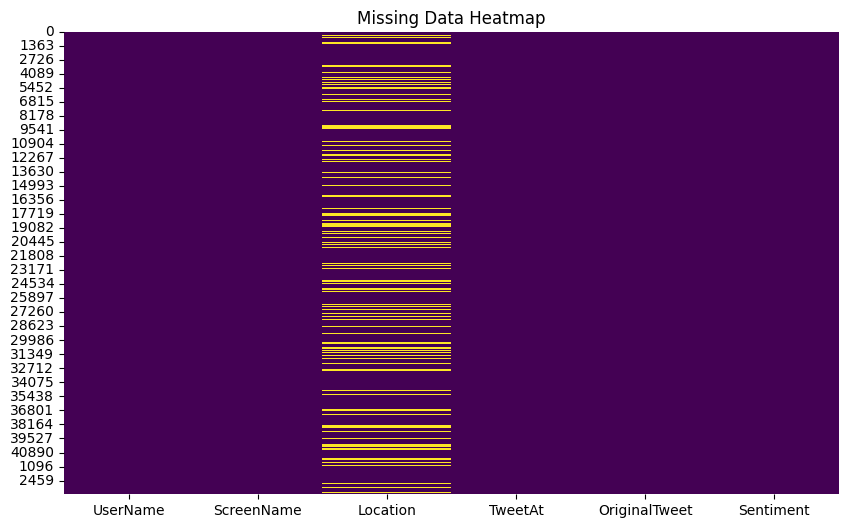

In [8]:
missing_data = x_df.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(x_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [9]:
print('Total tweets in this data: {}'.format(x_df.shape[0]))
print('Total Unique Users in this data: {}'.format(x_df['UserName'].nunique()))

Total tweets in this data: 44955
Total Unique Users in this data: 44955


In [10]:
print(x_df.Sentiment.unique())
print(x_df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64


In [11]:
# We will copy the text in another column so that the original text is also there for comparison

x_df['text'] = x_df.OriginalTweet
x_df["text"] = x_df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
x_df['sentiment']=x_df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=x_df['sentiment']

x_df.sentiment.value_counts(normalize= True)

sentiment
positive    0.435814
negative    0.378846
neutral     0.185341
Name: proportion, dtype: float64

In [12]:
class_df = x_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


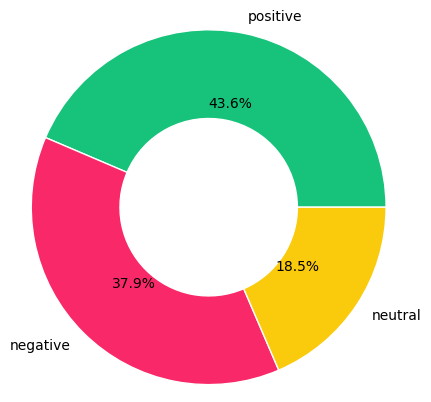

In [13]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,subplot_titles=('Train set','Test set'))



In [15]:
x = test.sentiment.value_counts()
fig.add_trace(go.Bar(x= x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

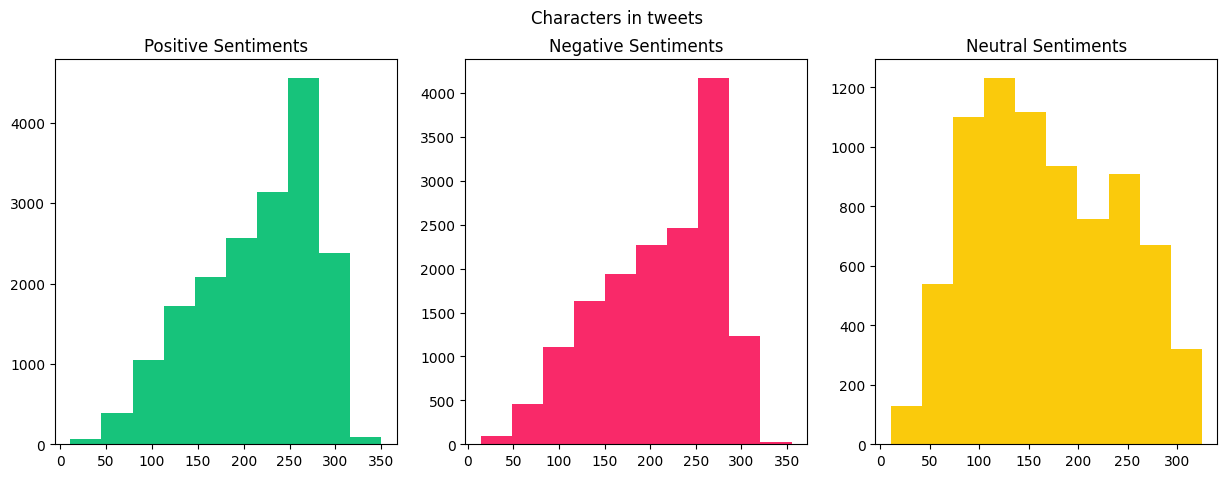

In [16]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

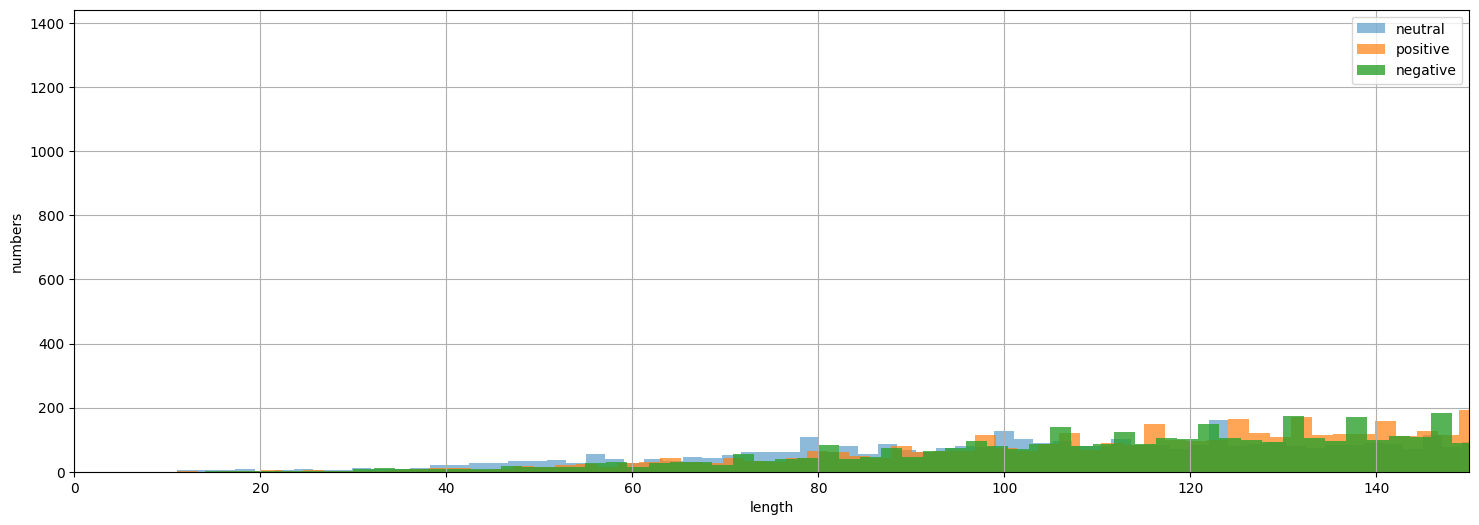

In [17]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
x_df['length'] = x_df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(x_df[x_df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(x_df[x_df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(x_df[x_df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

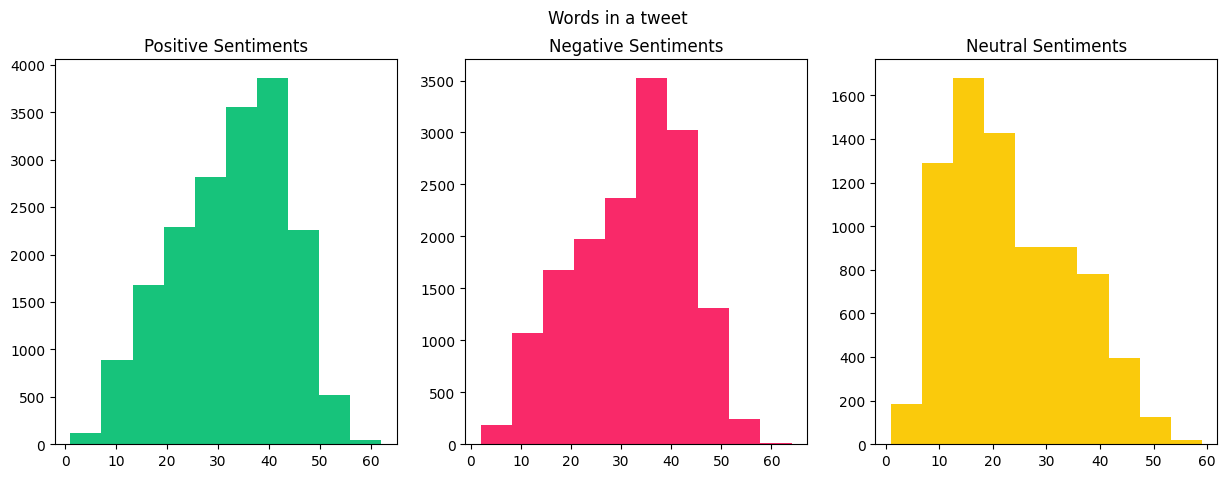

In [18]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

In [19]:
# x_df['TweetAt'] = pd.to_datetime(x_df['TweetAt'])
train['TweetAt'] = pd.to_datetime(train['TweetAt'])

/tmp/ipykernel_20/791336919.py:2: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [20]:
tweetat = train['TweetAt'].dt.month.value_counts().sort_index()
fig = px.pie(values=tweetat.values, 
             names=tweetat.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Tweet Percentage over Months",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [21]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
 6   text           44955 non-null  object
 7   sentiment      44955 non-null  object
 8   length         44955 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.4+ MB


In [22]:
sentiment = train["Sentiment"].value_counts()
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Category Pie Graph",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [23]:
def extract_term_frequencies_sorted(text_column):
    # Combine all text in the column into a single string
    combined_text = ' '.join(text_column)
    
    # Remove URLs
    combined_text = re.sub(r'http\S+', '', combined_text)
    
    # Tokenize the text into words
    words = nltk.word_tokenize(combined_text)
    
    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Remove custom words
    custom_words = set(['http', 'https', 'co'])
    filtered_words = [word for word in filtered_words if word.lower() not in custom_words]
    
    # Remove special characters and digits
    filtered_words = [word for word in filtered_words if word.isalpha()]
    
    # Calculate term frequencies
    term_frequencies = Counter(filtered_words)
    
    # Sort terms by frequency in descending order
    sorted_term_frequencies = dict(sorted(term_frequencies.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_term_frequencies

In [24]:
freq_df = extract_term_frequencies_sorted(train['OriginalTweet'])
term_frequencies_df = pd.DataFrame(list(freq_df.items()), columns=['Term', 'Frequency'])
top_10 = term_frequencies_df[:10]
fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, title = 'Rank of terms',
             template = 'simple_white')
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

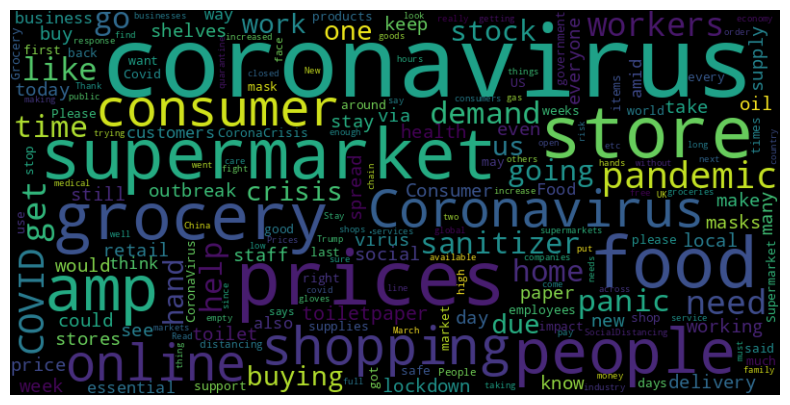

In [25]:
term_frequencies = dict(zip(term_frequencies_df['Term'], term_frequencies_df['Frequency']))
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(term_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
# Function to extract hashtags and their frequencies
def extract_hashtags(text_column):
    # Combine text from the 'TextColumn' into a single string
    combined_text = ' '.join(text_column)
    
    # Extract hashtags using regular expressions
    hashtags = re.findall(r'#\w+', combined_text)
    
    # Calculate hashtag frequencies
    hashtag_frequencies = Counter(hashtags)
    
    # Convert the Counter object to a DataFrame
    hashtag_df = pd.DataFrame(hashtag_frequencies.items(), columns=['Hashtag', 'Frequency'])
    
    return hashtag_df

In [27]:
hashtag_df = extract_hashtags(train['OriginalTweet'])

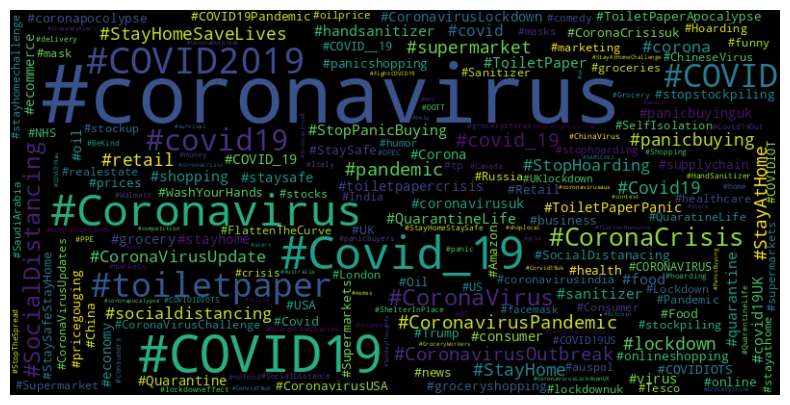

In [28]:
term_frequencies = dict(zip(hashtag_df['Hashtag'], hashtag_df['Frequency']))
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(term_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
# Function to extract mentions and their frequencies
def extract_mentions(text_column):
    # Combine text from the 'TextColumn' into a single string
    combined_text = ' '.join(text_column)
    
    # Extract mentions using regular expressions
    mentions = re.findall(r'@\w+', combined_text)
    
    # Calculate mention frequencies
    mention_frequencies = Counter(mentions)
    
    # Convert the Counter object to a DataFrame
    mention_df = pd.DataFrame(mention_frequencies.items(), columns=['Mention', 'Frequency'])
    
    return mention_df

In [30]:
mentions_df = extract_mentions(train['OriginalTweet'])

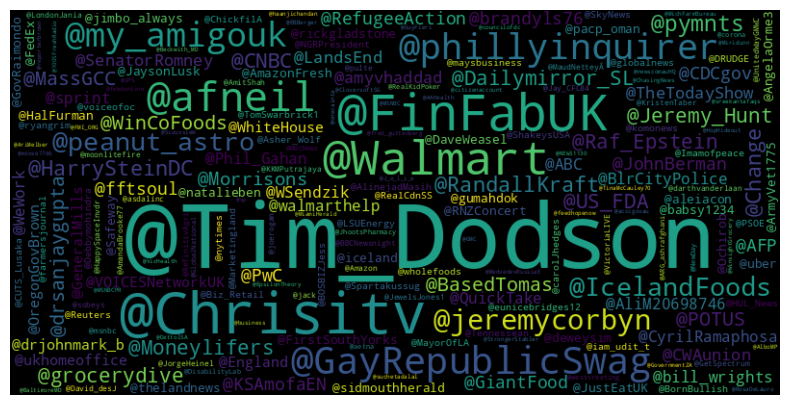

In [31]:
term_frequencies = dict(zip(mentions_df['Mention'], hashtag_df['Frequency']))
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(term_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()